In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from datetime import timedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
df_chicago = pd.read_csv('../dataset/chicago_2018_clean.csv')
df_weather = pd.read_csv('../dataset/chicago_weather_2018_clean.csv')

# Disclaimer: When we later on talk about demand, we always mean the hourly demand
# Also the column 'Demand' which will be added later on, is representing the hourly demand

In [5]:
df_sorted = df_chicago.sort_values(by=['start_time'], ascending = [True])
#print(df_sorted['start_time'].iloc[380])
df_sorted.head(9)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration_per_trip,trip_time_in_hours
3212538,2018-01-01 00:12:00,2018-01-01 00:17:23,69,159,Damen Ave & Pierce Ave,Claremont Ave & Hirsch St,3304,Subscriber,0 days 00:05:23,0.089722
3212539,2018-01-01 00:41:35,2018-01-01 00:47:52,253,325,Winthrop Ave & Lawrence Ave,Clark St & Winnemac Ave (Temp),5367,Subscriber,0 days 00:06:17,0.104722
3212540,2018-01-01 00:44:46,2018-01-01 01:33:10,98,509,LaSalle St & Washington St,Troy St & North Ave,4599,Subscriber,0 days 00:48:24,0.806667
3212541,2018-01-01 00:53:10,2018-01-01 01:05:37,125,364,Rush St & Hubbard St,Larrabee St & Oak St,2302,Subscriber,0 days 00:12:27,0.207500
3212542,2018-01-01 00:53:37,2018-01-01 00:56:40,129,205,Blue Island Ave & 18th St,Paulina St & 18th St,3696,Subscriber,0 days 00:03:03,0.050833
3212543,2018-01-01 00:56:15,2018-01-01 01:00:41,304,299,Broadway & Waveland Ave,Halsted St & Roscoe St,6298,Subscriber,0 days 00:04:26,0.073889
3212544,2018-01-01 00:57:26,2018-01-01 01:02:40,164,174,Franklin St & Lake St,Canal St & Madison St,1169,Subscriber,0 days 00:05:14,0.087222
3212545,2018-01-01 01:00:29,2018-01-01 01:13:43,182,142,Wells St & Elm St,McClurg Ct & Erie St,6351,Subscriber,0 days 00:13:14,0.220556
3212546,2018-01-01 01:07:12,2018-01-01 01:31:53,99,99,Lake Shore Dr & Ohio St,Lake Shore Dr & Ohio St,1920,Customer,0 days 00:24:41,0.411389


In [6]:
#rename date_time column of df_weather in order to successfully merge system load and weather dataframe later on
df_weather.rename(columns = {'date_time':'start_time'}, inplace = True)
#convert now start_time column to datetime format in order to merge later on
df_weather['start_time'] = pd.to_datetime(df_weather['start_time']) #TODO: wetter datei nochmal neu holen
df_weather.head(20)

,start_time,max_temp,min_temp,precip
0,2018-01-01 00:00:00,-13.9,-13.9,0.0
1,2018-01-01 01:00:00,-15.0,-15.0,0.0
2,2018-01-01 02:00:00,-15.6,-15.6,0.0
3,2018-01-01 03:00:00,-16.7,-16.7,0.0
4,2018-01-01 04:00:00,-17.2,-17.2,0.0
5,2018-01-01 05:00:00,-17.8,-17.8,0.0
6,2018-01-01 06:00:00,-18.3,-18.3,0.0
7,2018-01-01 07:00:00,-19.4,-19.4,0.0
8,2018-01-01 08:00:00,-20.0,-20.0,0.0
9,2018-01-01 09:00:00,-20.6,-20.6,0.0


In [7]:
#we calculate the hourly system demand by summing up the number of biketrips started in one hour
df_sorted['start_time'] = pd.to_datetime(df_sorted['start_time'])
df_sorted['end_time'] = pd.to_datetime(df_sorted['end_time'])
df_load = df_sorted.groupby([pd.Grouper(key='start_time',freq='H')]).size().reset_index(name='Demand')
df_load

,start_time,Demand
0,2018-01-01 00:00:00,7
1,2018-01-01 01:00:00,14
2,2018-01-01 02:00:00,10
3,2018-01-01 03:00:00,2
4,2018-01-01 04:00:00,2
...,...,...
8755,2018-12-31 19:00:00,41
8756,2018-12-31 20:00:00,28
8757,2018-12-31 21:00:00,22
8758,2018-12-31 22:00:00,25


In [8]:
# merge Demand dataframe with weather dataframe
# calculate average temperature within the hour to check correlation with demand later on

df_load_weather = pd.merge(df_load, df_weather, on='start_time')
#calculate average ter
df_load_weather['avg_temp'] = (df_load_weather['max_temp'] + df_load_weather['min_temp'])/2
#since we only inspect the average temperature in the hour, we can drop the max_temp and min_temp columns
df_load_weather.head(10)

,start_time,Demand,max_temp,min_temp,precip,avg_temp
0,2018-01-01 00:00:00,7,-13.9,-13.9,0.0,-13.9
1,2018-01-01 01:00:00,14,-15.0,-15.0,0.0,-15.0
2,2018-01-01 02:00:00,10,-15.6,-15.6,0.0,-15.6
3,2018-01-01 03:00:00,2,-16.7,-16.7,0.0,-16.7
4,2018-01-01 04:00:00,2,-17.2,-17.2,0.0,-17.2
5,2018-01-01 05:00:00,3,-17.8,-17.8,0.0,-17.8
6,2018-01-01 06:00:00,5,-18.3,-18.3,0.0,-18.3
7,2018-01-01 07:00:00,5,-19.4,-19.4,0.0,-19.4
8,2018-01-01 08:00:00,7,-20.0,-20.0,0.0,-20.0
9,2018-01-01 09:00:00,10,-20.6,-20.6,0.0,-20.6


In [9]:
df_load_weather.drop(['max_temp', 'min_temp'], axis = 1, inplace = True)
df_load_weather.head(10)

,start_time,Demand,precip,avg_temp
0,2018-01-01 00:00:00,7,0.0,-13.9
1,2018-01-01 01:00:00,14,0.0,-15.0
2,2018-01-01 02:00:00,10,0.0,-15.6
3,2018-01-01 03:00:00,2,0.0,-16.7
4,2018-01-01 04:00:00,2,0.0,-17.2
5,2018-01-01 05:00:00,3,0.0,-17.8
6,2018-01-01 06:00:00,5,0.0,-18.3
7,2018-01-01 07:00:00,5,0.0,-19.4
8,2018-01-01 08:00:00,7,0.0,-20.0
9,2018-01-01 09:00:00,10,0.0,-20.6


In [13]:
# create new column for only the hour of the starttime
# since calculating the correlation between a int object (Demand) and a datetime (start_time) object is tricky, 
# we save the hour of the starting time in a new column to make this operation easier

df_load_weather['start_hour'] = df_load_weather['start_time'].dt.hour

In [15]:
# Handeling cyclical data
# Since our algorithms later wont know that the hour 0 comes directly after the hour 23, we need to transform our
# time data in such a way that no important information is lost due to the unfitting representation of time
# We will use sinus and cosinus functions to connect the end of the day with the beginning of the next one

df_load_weather['sin_hour'] = np.sin(2*np.pi*df_load_weather['start_hour']/24)
df_load_weather['cos_hour'] = np.cos(2*np.pi*df_load_weather['start_hour']/24)
df_load_weather.head(25)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000e+00,1.000000e+00
1,2018-01-01 01:00:00,14,0.0,-15.0,1,2.588190e-01,9.659258e-01
2,2018-01-01 02:00:00,10,0.0,-15.6,2,5.000000e-01,8.660254e-01
3,2018-01-01 03:00:00,2,0.0,-16.7,3,7.071068e-01,7.071068e-01
4,2018-01-01 04:00:00,2,0.0,-17.2,4,8.660254e-01,5.000000e-01
5,2018-01-01 05:00:00,3,0.0,-17.8,5,9.659258e-01,2.588190e-01
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1.000000e+00,6.123234e-17
7,2018-01-01 07:00:00,5,0.0,-19.4,7,9.659258e-01,-2.588190e-01
8,2018-01-01 08:00:00,7,0.0,-20.0,8,8.660254e-01,-5.000000e-01
9,2018-01-01 09:00:00,10,0.0,-20.6,9,7.071068e-01,-7.071068e-01


In [23]:
# create new column for start_month
# same as for start_hour: we want to check the correlation between the month the trips are in and the demand
df_load_weather['start_month'] = df_load_weather['start_time'].dt.month

# The start month is also a cyclical feature, which is why we need also need to transform it
df_load_weather['sin_month'] = np.sin(2*np.pi*(df_load_weather['start_month'])/12)
df_load_weather['cos_month'] = np.cos(2*np.pi*df_load_weather['start_month']/12)

df_load_weather

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month
0,2018-01-01 00:00:00,7,0.0,-13.90,0,0.000000,1.000000,1,5.000000e-01,0.866025
1,2018-01-01 01:00:00,14,0.0,-15.00,1,0.258819,0.965926,1,5.000000e-01,0.866025
2,2018-01-01 02:00:00,10,0.0,-15.60,2,0.500000,0.866025,1,5.000000e-01,0.866025
3,2018-01-01 03:00:00,2,0.0,-16.70,3,0.707107,0.707107,1,5.000000e-01,0.866025
4,2018-01-01 04:00:00,2,0.0,-17.20,4,0.866025,0.500000,1,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,41,1.0,3.30,19,-0.965926,0.258819,12,-2.449294e-16,1.000000
8756,2018-12-31 20:00:00,28,1.0,3.60,20,-0.866025,0.500000,12,-2.449294e-16,1.000000
8757,2018-12-31 21:00:00,22,1.0,3.45,21,-0.707107,0.707107,12,-2.449294e-16,1.000000
8758,2018-12-31 22:00:00,25,0.0,3.30,22,-0.500000,0.866025,12,-2.449294e-16,1.000000


In [282]:
# holiday check
# following days where federal holidays in Illinois (the state chicago is located in):
# 01.01, 15.01, 12.02, 19.02, 05.03, 28.05, 04.07, 03.09, 08.10, 06.11, 12.11, 22.11, 23.11, 05.12, 24.12, 25.12
# source: TODO noch hinzufügen

holidays = np.array([
    datetime.date(2018,1,1),
    datetime.date(2018,1,15),
    datetime.date(2018,2,12),
    datetime.date(2018,2,19),
    datetime.date(2018,3,5),
    datetime.date(2018,5,28),
    datetime.date(2018,7,4),
    datetime.date(2018,9,3),
    datetime.date(2018,10,8),
    datetime.date(2018,11,6),
    datetime.date(2018,11,12),
    datetime.date(2018,11,22),
    datetime.date(2018,11,23),
    datetime.date(2018,12,5),
    datetime.date(2018,12,24),
    datetime.date(2018,12,25),
])
print(holidays)

#conditions = [df_load_weather['star_time'].date()= ]

[datetime.date(2018, 1, 1) datetime.date(2018, 1, 15)
 datetime.date(2018, 2, 12) datetime.date(2018, 2, 19)
 datetime.date(2018, 3, 5) datetime.date(2018, 5, 28)
 datetime.date(2018, 7, 4) datetime.date(2018, 9, 3)
 datetime.date(2018, 10, 8) datetime.date(2018, 11, 6)
 datetime.date(2018, 11, 12) datetime.date(2018, 11, 22)
 datetime.date(2018, 11, 23) datetime.date(2018, 12, 5)
 datetime.date(2018, 12, 24) datetime.date(2018, 12, 25)]


In [299]:
#create new column in df_load_weather to signal if day was a holiday
#Holiday column is important so we can later check, if there is a correlation between holidays and Demand
df_load_weather['start_time'] = pd.to_datetime(df_load_weather['start_time'])
df_load_weather['isHoliday'] = df_load_weather['start_time'].dt.date.isin(holidays)

# since we want to make sure that the correlation is calculated properly, we transform the currently boolean values
# of isHoliday to int values: 1 = this date was a holiday; 2 = this date wasn't a holiday
df_load_weather['isHoliday'] = df_load_weather['isHoliday'].astype(int)

df_load_weather.head(10)

,start_time,Demand,precip,avg_temp,start_hour,start_month,isHoliday
0,2018-01-01 00:00:00,7,0.0,-13.9,0,1,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,1,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,1,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,1,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,1,1
5,2018-01-01 05:00:00,3,0.0,-17.8,5,1,1
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1,1
7,2018-01-01 07:00:00,5,0.0,-19.4,7,1,1
8,2018-01-01 08:00:00,7,0.0,-20.0,8,1,1
9,2018-01-01 09:00:00,10,0.0,-20.6,9,1,1


In [25]:
# Create new column 'day_of_Week' in df_load_weather to determine, which weekday/weekend-day it was at this date
# Crate dummy-variables to symbolize differnt days of the week
# Explain Indizes: 1=Monday, 2=Tuesday, 3=Wednesday, 4=Thursday, 5=Friday, 6=Saturday, 7=Sunday
# Will be used later to check correlation between weekdays and system demand

df_load_weather['day_of_Week'] = df_load_weather['start_time'].dt.isocalendar().day

# Since day_of_Week is once again a cyclical feature, we again need to transform it in order to have continous data
# instead of interrupt changes when the new week begins

df_load_weather['sin_day_of_Week'] = np.sin(2*np.pi*df_load_weather['day_of_Week']/7)
df_load_weather['cos_day_of_Week'] = np.cos(2*np.pi*df_load_weather['day_of_Week']/7)
df_load_weather.head(500)


,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,day_of_Week,sin_day_of_Week,cos_day_of_Week
0,2018-01-01 00:00:00,7,0.0,-13.90,0,0.000000,1.000000e+00,1,0.5,0.866025,1,0.781831,0.62349
1,2018-01-01 01:00:00,14,0.0,-15.00,1,0.258819,9.659258e-01,1,0.5,0.866025,1,0.781831,0.62349
2,2018-01-01 02:00:00,10,0.0,-15.60,2,0.500000,8.660254e-01,1,0.5,0.866025,1,0.781831,0.62349
3,2018-01-01 03:00:00,2,0.0,-16.70,3,0.707107,7.071068e-01,1,0.5,0.866025,1,0.781831,0.62349
4,2018-01-01 04:00:00,2,0.0,-17.20,4,0.866025,5.000000e-01,1,0.5,0.866025,1,0.781831,0.62349
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2018-01-21 15:00:00,222,0.0,4.40,15,-0.707107,-7.071068e-01,1,0.5,0.866025,7,-0.0,1.0
496,2018-01-21 16:00:00,182,0.0,4.70,16,-0.866025,-5.000000e-01,1,0.5,0.866025,7,-0.0,1.0
497,2018-01-21 17:00:00,167,0.0,5.00,17,-0.965926,-2.588190e-01,1,0.5,0.866025,7,-0.0,1.0
498,2018-01-21 18:00:00,140,0.0,6.40,18,-1.000000,-1.836970e-16,1,0.5,0.866025,7,-0.0,1.0


In [26]:
# Create new column: season
# We later want to check the correlation between the season and the demand
# Create Dummy-Variables to symbolize different seasons
# Indizes Explanation: 1: Winter {Dec, Jan, Feb}; 2: Spring {Mar, April, May}; 3: Summer {June, July, Aug}; 4: Autumn {Sep, Oct, Nov}
# Seasons are technically also a cyclical feature, but since we only look at one year in our dataset, season don't
# occur more than once, hence no need for transforming the data
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

monthToSeason = dict(zip(range(1,13), seasons))

df_load_weather['season'] = df_load_weather['start_time'].dt.month.map(monthToSeason)
df_load_weather.head(7000)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,day_of_Week,sin_day_of_Week,cos_day_of_Week,season
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000e+00,1.000000,1,0.500000,0.866025,1,0.781831,0.62349,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,2.588190e-01,0.965926,1,0.500000,0.866025,1,0.781831,0.62349,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,5.000000e-01,0.866025,1,0.500000,0.866025,1,0.781831,0.62349,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,7.071068e-01,0.707107,1,0.500000,0.866025,1,0.781831,0.62349,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,8.660254e-01,0.500000,1,0.500000,0.866025,1,0.781831,0.62349,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,2018-10-19 11:00:00,327,0.0,7.8,11,2.588190e-01,-0.965926,10,-0.866025,0.500000,5,-0.974928,-0.222521,4
6996,2018-10-19 12:00:00,314,0.0,8.3,12,1.224647e-16,-1.000000,10,-0.866025,0.500000,5,-0.974928,-0.222521,4
6997,2018-10-19 13:00:00,282,0.0,8.9,13,-2.588190e-01,-0.965926,10,-0.866025,0.500000,5,-0.974928,-0.222521,4
6998,2018-10-19 14:00:00,302,0.0,9.4,14,-5.000000e-01,-0.866025,10,-0.866025,0.500000,5,-0.974928,-0.222521,4


In [27]:
# Create new column for possible feature: rush_Hour
# We will check later, if a correlatio between datasets in the rush_Hour and the Demand exists
# Rushhour in chicago is between (06:00am and 08:00) am and (04:00pm and 06:00pm)


df_load_weather['in_rush_Hour'] = False
df_load_weather['in_rush_Hour'] = np.where((df_load_weather['start_time'].dt.time.ge(datetime.time(6,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(8,0,0)))
                                              | (df_load_weather['start_time'].dt.time.ge(datetime.time(16,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(18,0,0))),1,0
                                          
                                          )



In [28]:
df_load_weather.head(25)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000e+00,1.000000e+00,1,0.5,0.866025,1,0.781831,0.62349,1,0
1,2018-01-01 01:00:00,14,0.0,-15.0,1,2.588190e-01,9.659258e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0
2,2018-01-01 02:00:00,10,0.0,-15.6,2,5.000000e-01,8.660254e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,7.071068e-01,7.071068e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,8.660254e-01,5.000000e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0
5,2018-01-01 05:00:00,3,0.0,-17.8,5,9.659258e-01,2.588190e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1.000000e+00,6.123234e-17,1,0.5,0.866025,1,0.781831,0.62349,1,1
7,2018-01-01 07:00:00,5,0.0,-19.4,7,9.659258e-01,-2.588190e-01,1,0.5,0.866025,1,0.781831,0.62349,1,1
8,2018-01-01 08:00:00,7,0.0,-20.0,8,8.660254e-01,-5.000000e-01,1,0.5,0.866025,1,0.781831,0.62349,1,1
9,2018-01-01 09:00:00,10,0.0,-20.6,9,7.071068e-01,-7.071068e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0


In [29]:
#Create new column prev_Demand to later check if there is a correlation between the demand of the previous hour and the current one

df_load_weather['prev_Demand'] = df_load_weather['Demand'].shift()
df_load_weather.head(10)


,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000e+00,1,0.5,0.866025,1,0.781831,0.62349,1,0,NaN
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,9.659258e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,7.0
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,8.660254e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,14.0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,7.071068e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,10.0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,5.000000e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,2.0
5,2018-01-01 05:00:00,3,0.0,-17.8,5,0.965926,2.588190e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,2.0
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1.000000,6.123234e-17,1,0.5,0.866025,1,0.781831,0.62349,1,1,3.0
7,2018-01-01 07:00:00,5,0.0,-19.4,7,0.965926,-2.588190e-01,1,0.5,0.866025,1,0.781831,0.62349,1,1,5.0
8,2018-01-01 08:00:00,7,0.0,-20.0,8,0.866025,-5.000000e-01,1,0.5,0.866025,1,0.781831,0.62349,1,1,5.0
9,2018-01-01 09:00:00,10,0.0,-20.6,9,0.707107,-7.071068e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,7.0


In [30]:
# Create new column prev_Demand2
# We found that the correlation between the Demand one hour before the inspected hour was so high (ca 0.85) we will
# also check if the demand two hours ago also has such an outstanding correlation with the demand

df_load_weather['prev_Demand2'] = df_load_weather['prev_Demand'].shift()
df_load_weather.head(10)


,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand,prev_Demand2
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000e+00,1,0.5,0.866025,1,0.781831,0.62349,1,0,NaN,NaN
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,9.659258e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,7.0,NaN
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,8.660254e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,14.0,7.0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,7.071068e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,10.0,14.0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,5.000000e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,2.0,10.0
5,2018-01-01 05:00:00,3,0.0,-17.8,5,0.965926,2.588190e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,2.0,2.0
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1.000000,6.123234e-17,1,0.5,0.866025,1,0.781831,0.62349,1,1,3.0,2.0
7,2018-01-01 07:00:00,5,0.0,-19.4,7,0.965926,-2.588190e-01,1,0.5,0.866025,1,0.781831,0.62349,1,1,5.0,3.0
8,2018-01-01 08:00:00,7,0.0,-20.0,8,0.866025,-5.000000e-01,1,0.5,0.866025,1,0.781831,0.62349,1,1,5.0,5.0
9,2018-01-01 09:00:00,10,0.0,-20.6,9,0.707107,-7.071068e-01,1,0.5,0.866025,1,0.781831,0.62349,1,0,7.0,5.0


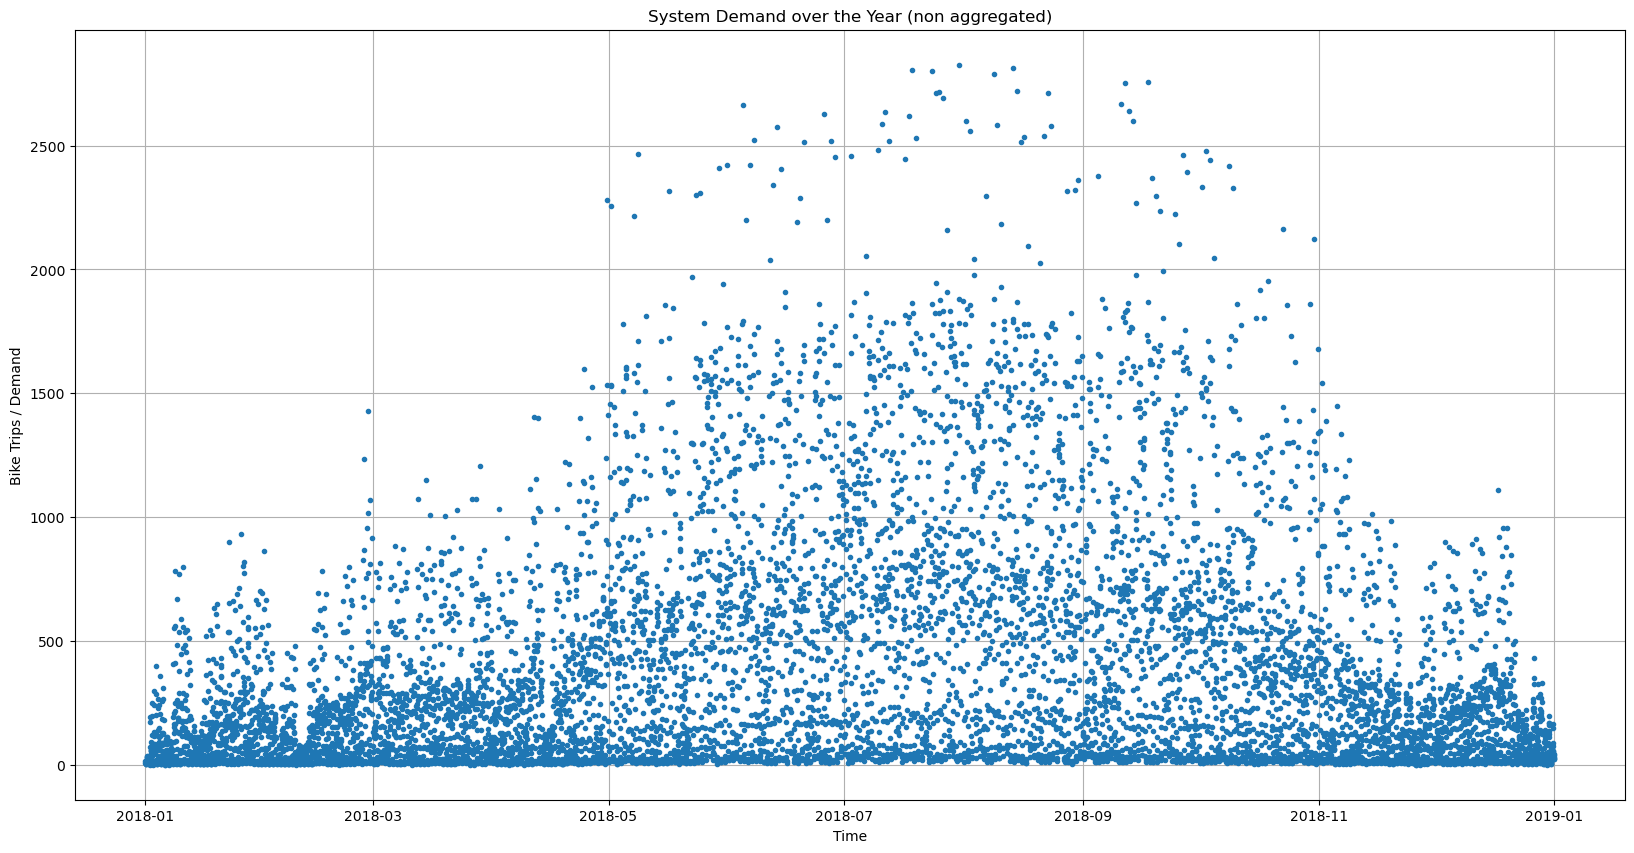

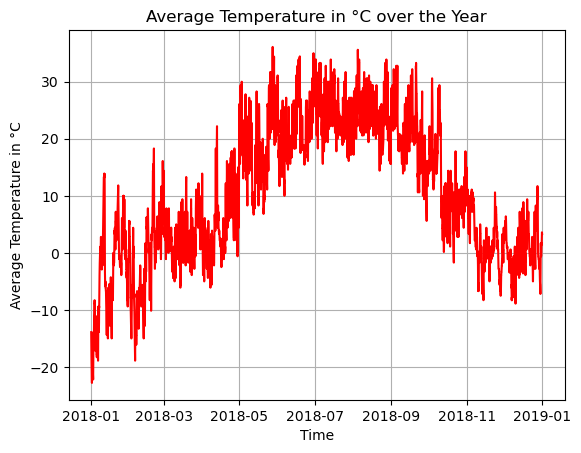

In [31]:
#to visualize our system demand, we create a plot
plt.plot(df_load_weather['start_time'], df_load_weather['Demand'], '.')
plt.title('System Demand over the Year (non aggregated)')
plt.xlabel('Time')
plt.ylabel('Bike Trips / Demand')
plt.grid(True)

plt.gcf().set_size_inches(20,10)
plt.show()

plt.plot(df_load_weather['start_time'],df_load_weather['avg_temp'], "r-")
plt.title('Average Temperature in °C over the Year')
plt.xlabel('Time')
plt.ylabel('Average Temperature in °C')
plt.grid(True)
plt.show()


In [45]:
# Feature Selection

# We start by performing a Lasso (L1 regularization) regression on our dataset, in order to obtain the importance
# of our features

#We start calculating the Pearson's correlation of each column with the demand to determine, which features
# are actually worth keeping for the regression
df_load_weather.drop('level_0', axis= 1, inplace = True)
df_load_weather.head()

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand,prev_Demand2
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025,1,0.781831,0.62349,1,0,NaN,NaN
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025,1,0.781831,0.62349,1,0,7.0,NaN
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025,1,0.781831,0.62349,1,0,14.0,7.0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025,1,0.781831,0.62349,1,0,10.0,14.0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025,1,0.781831,0.62349,1,0,2.0,10.0


In [47]:
# First of all we split the data into our training and testing data, since we only compute our correlation
# and later regression also on our training data

# trying lasso regression for eliminating useless features and avoid overfitting



# x are out features
X = df_load_weather.drop('Demand', axis = 1)

# setting start_time as index, data is saved in start_day and start_month
# regression does not work with datetime objects, which is why we only save it as index and the acutal data (day, month, hour)
# as integer

X.set_index('start_time',inplace = True)
#print(X)

#X['start_time'] = pd.to_datetime(X['start_time'])
# y is our label
y = df_load_weather['Demand']

#splitting data into training and testing data, with testing data being 30% of our dataset
#random_state just a variable for randomizing which values are used for training and which are used for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.fillna(X_train.mean(), inplace=True)
# since lasso regression puts a lot of penalty on high magnitudes of features, scaling our features is essential
# in order to obtain precise results
# Normalizing of features: 

pipeline = Pipeline([('scaler',StandardScaler()),
                    ('model', Lasso())
                     ])

# for finding the optimal value for lamda (also called alpha in a lot of literature) we utilize a Grid Search

search = GridSearchCV (pipeline,
                      {'model__alpha': np.arange(0.1, 50, 0.1)},
                      cv = 5, scoring = "neg_mean_squared_error", verbose=3
                      )

# when increasing the lambda range from 10 to 100, the optimal value remains at 0.1
# we can conclude that the optimal lambda value for this data set is indeed 0.1 => very limited regularization

search.fit(X_train, y_train)
search.best_params_


Fitting 5 folds for each of 499 candidates, totalling 2495 fits
[CV 1/5] END .............model__alpha=0.1;, score=-31009.469 total time=   0.0s
[CV 2/5] END .............model__alpha=0.1;, score=-39678.067 total time=   0.0s
[CV 3/5] END .............model__alpha=0.1;, score=-38166.467 total time=   0.0s
[CV 4/5] END .............model__alpha=0.1;, score=-38449.829 total time=   0.0s
[CV 5/5] END .............model__alpha=0.1;, score=-36696.231 total time=   0.0s
[CV 1/5] END .............model__alpha=0.2;, score=-30994.838 total time=   0.0s
[CV 2/5] END .............model__alpha=0.2;, score=-39691.080 total time=   0.0s
[CV 3/5] END .............model__alpha=0.2;, score=-38153.855 total time=   0.0s
[CV 4/5] END .............model__alpha=0.2;, score=-38464.832 total time=   0.0s
[CV 5/5] END .............model__alpha=0.2;, score=-36696.725 total time=   0.0s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-30981.390 total time=   0.0s
[CV 2/5] END model__alpha=0.30000000000000

[CV 2/5] END .............model__alpha=2.1;, score=-40117.045 total time=   0.0s
[CV 3/5] END .............model__alpha=2.1;, score=-37885.813 total time=   0.0s
[CV 4/5] END .............model__alpha=2.1;, score=-38945.779 total time=   0.0s
[CV 5/5] END .............model__alpha=2.1;, score=-36904.885 total time=   0.0s
[CV 1/5] END .............model__alpha=2.2;, score=-30937.599 total time=   0.0s
[CV 2/5] END .............model__alpha=2.2;, score=-40148.019 total time=   0.0s
[CV 3/5] END .............model__alpha=2.2;, score=-37879.027 total time=   0.0s
[CV 4/5] END .............model__alpha=2.2;, score=-38975.852 total time=   0.0s
[CV 5/5] END .............model__alpha=2.2;, score=-36923.588 total time=   0.0s
[CV 1/5] END model__alpha=2.3000000000000003;, score=-30943.221 total time=   0.0s
[CV 2/5] END model__alpha=2.3000000000000003;, score=-40179.796 total time=   0.0s
[CV 3/5] END model__alpha=2.3000000000000003;, score=-37873.092 total time=   0.0s
[CV 4/5] END model__al

[CV 4/5] END .............model__alpha=4.1;, score=-39588.442 total time=   0.0s
[CV 5/5] END .............model__alpha=4.1;, score=-37365.859 total time=   0.0s
[CV 1/5] END .............model__alpha=4.2;, score=-30998.832 total time=   0.0s
[CV 2/5] END .............model__alpha=4.2;, score=-40796.331 total time=   0.0s
[CV 3/5] END .............model__alpha=4.2;, score=-37870.934 total time=   0.0s
[CV 4/5] END .............model__alpha=4.2;, score=-39624.415 total time=   0.0s
[CV 5/5] END .............model__alpha=4.2;, score=-37393.231 total time=   0.0s
[CV 1/5] END .............model__alpha=4.3;, score=-31005.347 total time=   0.0s
[CV 2/5] END .............model__alpha=4.3;, score=-40834.162 total time=   0.0s
[CV 3/5] END .............model__alpha=4.3;, score=-37875.364 total time=   0.0s
[CV 4/5] END .............model__alpha=4.3;, score=-39660.888 total time=   0.0s
[CV 5/5] END .............model__alpha=4.3;, score=-37421.158 total time=   0.0s
[CV 1/5] END model__alpha=4.

[CV 2/5] END .............model__alpha=6.2;, score=-41643.106 total time=   0.0s
[CV 3/5] END .............model__alpha=6.2;, score=-38061.237 total time=   0.0s
[CV 4/5] END .............model__alpha=6.2;, score=-40449.362 total time=   0.0s
[CV 5/5] END .............model__alpha=6.2;, score=-38057.935 total time=   0.0s
[CV 1/5] END .............model__alpha=6.3;, score=-31233.603 total time=   0.0s
[CV 2/5] END .............model__alpha=6.3;, score=-41692.291 total time=   0.0s
[CV 3/5] END .............model__alpha=6.3;, score=-38076.403 total time=   0.0s
[CV 4/5] END .............model__alpha=6.3;, score=-40495.843 total time=   0.0s
[CV 5/5] END .............model__alpha=6.3;, score=-38096.973 total time=   0.0s
[CV 1/5] END .............model__alpha=6.4;, score=-31249.927 total time=   0.0s
[CV 2/5] END .............model__alpha=6.4;, score=-41741.035 total time=   0.0s
[CV 3/5] END .............model__alpha=6.4;, score=-38092.106 total time=   0.0s
[CV 4/5] END .............mo

[CV 2/5] END .............model__alpha=8.3;, score=-42771.454 total time=   0.0s
[CV 3/5] END .............model__alpha=8.3;, score=-38492.303 total time=   0.0s
[CV 4/5] END .............model__alpha=8.3;, score=-41531.016 total time=   0.0s
[CV 5/5] END .............model__alpha=8.3;, score=-38995.038 total time=   0.0s
[CV 1/5] END .............model__alpha=8.4;, score=-31674.489 total time=   0.0s
[CV 2/5] END .............model__alpha=8.4;, score=-42828.431 total time=   0.0s
[CV 3/5] END .............model__alpha=8.4;, score=-38518.743 total time=   0.0s
[CV 4/5] END .............model__alpha=8.4;, score=-41588.627 total time=   0.0s
[CV 5/5] END .............model__alpha=8.4;, score=-39045.832 total time=   0.0s
[CV 1/5] END .............model__alpha=8.5;, score=-31700.622 total time=   0.0s
[CV 2/5] END .............model__alpha=8.5;, score=-42885.945 total time=   0.0s
[CV 3/5] END .............model__alpha=8.5;, score=-38545.720 total time=   0.0s
[CV 4/5] END .............mo

[CV 2/5] END ............model__alpha=10.4;, score=-44083.617 total time=   0.0s
[CV 3/5] END ............model__alpha=10.4;, score=-39160.217 total time=   0.0s
[CV 4/5] END ............model__alpha=10.4;, score=-42786.051 total time=   0.0s
[CV 5/5] END ............model__alpha=10.4;, score=-40111.632 total time=   0.0s
[CV 1/5] END ............model__alpha=10.5;, score=-32292.347 total time=   0.0s
[CV 2/5] END ............model__alpha=10.5;, score=-44151.891 total time=   0.0s
[CV 3/5] END ............model__alpha=10.5;, score=-39197.929 total time=   0.0s
[CV 4/5] END ............model__alpha=10.5;, score=-42850.569 total time=   0.0s
[CV 5/5] END ............model__alpha=10.5;, score=-40167.444 total time=   0.0s
[CV 1/5] END ............model__alpha=10.6;, score=-32325.948 total time=   0.0s
[CV 2/5] END ............model__alpha=10.6;, score=-44220.703 total time=   0.0s
[CV 3/5] END ............model__alpha=10.6;, score=-39236.187 total time=   0.0s
[CV 4/5] END ............mod

[CV 3/5] END ............model__alpha=12.4;, score=-40013.034 total time=   0.0s
[CV 4/5] END ............model__alpha=12.4;, score=-44052.285 total time=   0.0s
[CV 5/5] END ............model__alpha=12.4;, score=-41325.028 total time=   0.0s
[CV 1/5] END ............model__alpha=12.5;, score=-33049.046 total time=   0.0s
[CV 2/5] END ............model__alpha=12.5;, score=-45603.021 total time=   0.0s
[CV 3/5] END ............model__alpha=12.5;, score=-40061.072 total time=   0.0s
[CV 4/5] END ............model__alpha=12.5;, score=-44115.281 total time=   0.0s
[CV 5/5] END ............model__alpha=12.5;, score=-41390.966 total time=   0.0s
[CV 1/5] END ............model__alpha=12.6;, score=-33091.531 total time=   0.0s
[CV 2/5] END ............model__alpha=12.6;, score=-45680.378 total time=   0.0s
[CV 3/5] END ............model__alpha=12.6;, score=-40109.622 total time=   0.0s
[CV 4/5] END ............model__alpha=12.6;, score=-44178.687 total time=   0.0s
[CV 5/5] END ............mod

[CV 3/5] END ............model__alpha=14.5;, score=-41075.369 total time=   0.0s
[CV 4/5] END ............model__alpha=14.5;, score=-45331.363 total time=   0.0s
[CV 5/5] END ............model__alpha=14.5;, score=-42816.237 total time=   0.0s
[CV 1/5] END ............model__alpha=14.6;, score=-34002.150 total time=   0.0s
[CV 2/5] END ............model__alpha=14.6;, score=-47338.916 total time=   0.0s
[CV 3/5] END ............model__alpha=14.6;, score=-41128.003 total time=   0.0s
[CV 4/5] END ............model__alpha=14.6;, score=-45382.139 total time=   0.0s
[CV 5/5] END ............model__alpha=14.6;, score=-42892.827 total time=   0.0s
[CV 1/5] END model__alpha=14.700000000000001;, score=-34049.549 total time=   0.0s
[CV 2/5] END model__alpha=14.700000000000001;, score=-47427.412 total time=   0.0s
[CV 3/5] END model__alpha=14.700000000000001;, score=-41181.091 total time=   0.0s
[CV 4/5] END model__alpha=14.700000000000001;, score=-45433.226 total time=   0.0s
[CV 5/5] END model__

[CV 1/5] END ............model__alpha=16.6;, score=-34823.844 total time=   0.0s
[CV 2/5] END ............model__alpha=16.6;, score=-48910.152 total time=   0.0s
[CV 3/5] END ............model__alpha=16.6;, score=-42099.969 total time=   0.0s
[CV 4/5] END ............model__alpha=16.6;, score=-46463.264 total time=   0.0s
[CV 5/5] END ............model__alpha=16.6;, score=-44280.816 total time=   0.0s
[CV 1/5] END model__alpha=16.700000000000003;, score=-34863.913 total time=   0.0s
[CV 2/5] END model__alpha=16.700000000000003;, score=-48988.362 total time=   0.0s
[CV 3/5] END model__alpha=16.700000000000003;, score=-42145.878 total time=   0.0s
[CV 4/5] END model__alpha=16.700000000000003;, score=-46520.549 total time=   0.0s
[CV 5/5] END model__alpha=16.700000000000003;, score=-44349.560 total time=   0.0s
[CV 1/5] END ............model__alpha=16.8;, score=-34904.305 total time=   0.0s
[CV 2/5] END ............model__alpha=16.8;, score=-49066.951 total time=   0.0s
[CV 3/5] END .....

[CV 2/5] END model__alpha=18.700000000000003;, score=-49733.347 total time=   0.0s
[CV 3/5] END model__alpha=18.700000000000003;, score=-43118.888 total time=   0.0s
[CV 4/5] END model__alpha=18.700000000000003;, score=-47688.339 total time=   0.0s
[CV 5/5] END model__alpha=18.700000000000003;, score=-45207.604 total time=   0.0s
[CV 1/5] END ............model__alpha=18.8;, score=-35779.634 total time=   0.0s
[CV 2/5] END ............model__alpha=18.8;, score=-49751.263 total time=   0.0s
[CV 3/5] END ............model__alpha=18.8;, score=-43168.117 total time=   0.0s
[CV 4/5] END ............model__alpha=18.8;, score=-47705.756 total time=   0.0s
[CV 5/5] END ............model__alpha=18.8;, score=-45222.177 total time=   0.0s
[CV 1/5] END model__alpha=18.900000000000002;, score=-35826.754 total time=   0.0s
[CV 2/5] END model__alpha=18.900000000000002;, score=-49769.256 total time=   0.0s
[CV 3/5] END model__alpha=18.900000000000002;, score=-43217.904 total time=   0.0s
[CV 4/5] END m

[CV 1/5] END model__alpha=20.900000000000002;, score=-36276.014 total time=   0.0s
[CV 2/5] END model__alpha=20.900000000000002;, score=-50145.234 total time=   0.0s
[CV 3/5] END model__alpha=20.900000000000002;, score=-43415.063 total time=   0.0s
[CV 4/5] END model__alpha=20.900000000000002;, score=-48090.686 total time=   0.0s
[CV 5/5] END model__alpha=20.900000000000002;, score=-45526.281 total time=   0.0s
[CV 1/5] END model__alpha=21.000000000000004;, score=-36285.821 total time=   0.0s
[CV 2/5] END model__alpha=21.000000000000004;, score=-50164.843 total time=   0.0s
[CV 3/5] END model__alpha=21.000000000000004;, score=-43421.938 total time=   0.0s
[CV 4/5] END model__alpha=21.000000000000004;, score=-48109.523 total time=   0.0s
[CV 5/5] END model__alpha=21.000000000000004;, score=-45538.757 total time=   0.0s
[CV 1/5] END ............model__alpha=21.1;, score=-36294.946 total time=   0.0s
[CV 2/5] END ............model__alpha=21.1;, score=-50184.529 total time=   0.0s
[CV 3/5]

[CV 4/5] END model__alpha=23.000000000000004;, score=-48444.257 total time=   0.0s
[CV 5/5] END model__alpha=23.000000000000004;, score=-45795.571 total time=   0.0s
[CV 1/5] END ............model__alpha=23.1;, score=-36498.250 total time=   0.0s
[CV 2/5] END ............model__alpha=23.1;, score=-50586.874 total time=   0.0s
[CV 3/5] END ............model__alpha=23.1;, score=-43581.995 total time=   0.0s
[CV 4/5] END ............model__alpha=23.1;, score=-48461.651 total time=   0.0s
[CV 5/5] END ............model__alpha=23.1;, score=-45808.968 total time=   0.0s
[CV 1/5] END model__alpha=23.200000000000003;, score=-36508.936 total time=   0.0s
[CV 2/5] END model__alpha=23.200000000000003;, score=-50605.594 total time=   0.0s
[CV 3/5] END model__alpha=23.200000000000003;, score=-43589.955 total time=   0.0s
[CV 4/5] END model__alpha=23.200000000000003;, score=-48479.112 total time=   0.0s
[CV 5/5] END model__alpha=23.200000000000003;, score=-45822.421 total time=   0.0s
[CV 1/5] END m

[CV 2/5] END model__alpha=25.200000000000003;, score=-50997.109 total time=   0.0s
[CV 3/5] END model__alpha=25.200000000000003;, score=-43761.808 total time=   0.0s
[CV 4/5] END model__alpha=25.200000000000003;, score=-48843.763 total time=   0.0s
[CV 5/5] END model__alpha=25.200000000000003;, score=-46103.807 total time=   0.0s
[CV 1/5] END model__alpha=25.300000000000004;, score=-36747.678 total time=   0.0s
[CV 2/5] END model__alpha=25.300000000000004;, score=-51017.283 total time=   0.0s
[CV 3/5] END model__alpha=25.300000000000004;, score=-43771.028 total time=   0.0s
[CV 4/5] END model__alpha=25.300000000000004;, score=-48862.638 total time=   0.0s
[CV 5/5] END model__alpha=25.300000000000004;, score=-46118.453 total time=   0.0s
[CV 1/5] END model__alpha=25.400000000000002;, score=-36759.668 total time=   0.0s
[CV 2/5] END model__alpha=25.400000000000002;, score=-51037.542 total time=   0.0s
[CV 3/5] END model__alpha=25.400000000000002;, score=-43780.306 total time=   0.0s
[CV 

[CV 4/5] END model__alpha=27.400000000000002;, score=-49275.204 total time=   0.0s
[CV 5/5] END model__alpha=27.400000000000002;, score=-46439.339 total time=   0.0s
[CV 1/5] END model__alpha=27.500000000000004;, score=-37025.772 total time=   0.0s
[CV 2/5] END model__alpha=27.500000000000004;, score=-51471.778 total time=   0.0s
[CV 3/5] END model__alpha=27.500000000000004;, score=-43990.100 total time=   0.0s
[CV 4/5] END model__alpha=27.500000000000004;, score=-49296.250 total time=   0.0s
[CV 5/5] END model__alpha=27.500000000000004;, score=-46455.731 total time=   0.0s
[CV 1/5] END ............model__alpha=27.6;, score=-37039.013 total time=   0.0s
[CV 2/5] END ............model__alpha=27.6;, score=-51492.490 total time=   0.0s
[CV 3/5] END ............model__alpha=27.6;, score=-44000.713 total time=   0.0s
[CV 4/5] END ............model__alpha=27.6;, score=-49316.632 total time=   0.0s
[CV 5/5] END ............model__alpha=27.6;, score=-46471.655 total time=   0.0s
[CV 1/5] END m

[CV 3/5] END ............model__alpha=29.6;, score=-44225.129 total time=   0.0s
[CV 4/5] END ............model__alpha=29.6;, score=-49738.002 total time=   0.0s
[CV 5/5] END ............model__alpha=29.6;, score=-46802.470 total time=   0.0s
[CV 1/5] END model__alpha=29.700000000000003;, score=-37331.152 total time=   0.0s
[CV 2/5] END model__alpha=29.700000000000003;, score=-51943.704 total time=   0.0s
[CV 3/5] END model__alpha=29.700000000000003;, score=-44236.964 total time=   0.0s
[CV 4/5] END model__alpha=29.700000000000003;, score=-49759.739 total time=   0.0s
[CV 5/5] END model__alpha=29.700000000000003;, score=-46819.574 total time=   0.0s
[CV 1/5] END model__alpha=29.800000000000004;, score=-37345.630 total time=   0.0s
[CV 2/5] END model__alpha=29.800000000000004;, score=-51966.642 total time=   0.0s
[CV 3/5] END model__alpha=29.800000000000004;, score=-44248.858 total time=   0.0s
[CV 4/5] END model__alpha=29.800000000000004;, score=-49781.543 total time=   0.0s
[CV 5/5] E

[CV 3/5] END model__alpha=31.800000000000004;, score=-44498.883 total time=   0.0s
[CV 4/5] END model__alpha=31.800000000000004;, score=-50227.150 total time=   0.0s
[CV 5/5] END model__alpha=31.800000000000004;, score=-47190.021 total time=   0.0s
[CV 1/5] END model__alpha=31.900000000000002;, score=-37656.412 total time=   0.0s
[CV 2/5] END model__alpha=31.900000000000002;, score=-52447.072 total time=   0.0s
[CV 3/5] END model__alpha=31.900000000000002;, score=-44511.992 total time=   0.0s
[CV 4/5] END model__alpha=31.900000000000002;, score=-50250.097 total time=   0.0s
[CV 5/5] END model__alpha=31.900000000000002;, score=-47208.097 total time=   0.0s
[CV 1/5] END ............model__alpha=32.0;, score=-37671.897 total time=   0.0s
[CV 2/5] END ............model__alpha=32.0;, score=-52470.606 total time=   0.0s
[CV 3/5] END ............model__alpha=32.0;, score=-44525.159 total time=   0.0s
[CV 4/5] END ............model__alpha=32.0;, score=-50273.109 total time=   0.0s
[CV 5/5] END

[CV 4/5] END model__alpha=33.800000000000004;, score=-50698.348 total time=   0.0s
[CV 5/5] END model__alpha=33.800000000000004;, score=-47564.503 total time=   0.0s
[CV 1/5] END model__alpha=33.900000000000006;, score=-37976.822 total time=   0.0s
[CV 2/5] END model__alpha=33.900000000000006;, score=-52929.120 total time=   0.0s
[CV 3/5] END model__alpha=33.900000000000006;, score=-44786.338 total time=   0.0s
[CV 4/5] END model__alpha=33.900000000000006;, score=-50722.589 total time=   0.0s
[CV 5/5] END model__alpha=33.900000000000006;, score=-47583.787 total time=   0.0s
[CV 1/5] END ............model__alpha=34.0;, score=-37993.431 total time=   0.0s
[CV 2/5] END ............model__alpha=34.0;, score=-52953.850 total time=   0.0s
[CV 3/5] END ............model__alpha=34.0;, score=-44800.665 total time=   0.0s
[CV 4/5] END ............model__alpha=34.0;, score=-50746.894 total time=   0.0s
[CV 5/5] END ............model__alpha=34.0;, score=-47603.125 total time=   0.0s
[CV 1/5] END .

[CV 5/5] END model__alpha=35.900000000000006;, score=-47980.929 total time=   0.0s
[CV 1/5] END ............model__alpha=36.0;, score=-38337.317 total time=   0.0s
[CV 2/5] END ............model__alpha=36.0;, score=-53460.957 total time=   0.0s
[CV 3/5] END ............model__alpha=36.0;, score=-45099.372 total time=   0.0s
[CV 4/5] END ............model__alpha=36.0;, score=-51246.497 total time=   0.0s
[CV 5/5] END ............model__alpha=36.0;, score=-48001.355 total time=   0.0s
[CV 1/5] END ............model__alpha=36.1;, score=-38355.098 total time=   0.0s
[CV 2/5] END ............model__alpha=36.1;, score=-53486.937 total time=   0.0s
[CV 3/5] END ............model__alpha=36.1;, score=-45114.915 total time=   0.0s
[CV 4/5] END ............model__alpha=36.1;, score=-51272.151 total time=   0.0s
[CV 5/5] END ............model__alpha=36.1;, score=-48021.836 total time=   0.0s
[CV 1/5] END ............model__alpha=36.2;, score=-38372.934 total time=   0.0s
[CV 2/5] END ............m

[CV 1/5] END ............model__alpha=38.0;, score=-38703.498 total time=   0.0s
[CV 2/5] END ............model__alpha=38.0;, score=-53991.891 total time=   0.0s
[CV 3/5] END ............model__alpha=38.0;, score=-45421.232 total time=   0.0s
[CV 4/5] END ............model__alpha=38.0;, score=-51771.799 total time=   0.0s
[CV 5/5] END ............model__alpha=38.0;, score=-48421.302 total time=   0.0s
[CV 1/5] END ............model__alpha=38.1;, score=-38722.392 total time=   0.0s
[CV 2/5] END ............model__alpha=38.1;, score=-54019.063 total time=   0.0s
[CV 3/5] END ............model__alpha=38.1;, score=-45437.933 total time=   0.0s
[CV 4/5] END ............model__alpha=38.1;, score=-51798.742 total time=   0.0s
[CV 5/5] END ............model__alpha=38.1;, score=-48442.869 total time=   0.0s
[CV 1/5] END ............model__alpha=38.2;, score=-38741.341 total time=   0.0s
[CV 2/5] END ............model__alpha=38.2;, score=-54046.294 total time=   0.0s
[CV 3/5] END ............mod

[CV 5/5] END model__alpha=40.00000000000001;, score=-48862.929 total time=   0.0s
[CV 1/5] END ............model__alpha=40.1;, score=-39111.942 total time=   0.0s
[CV 2/5] END ............model__alpha=40.1;, score=-54574.995 total time=   0.0s
[CV 3/5] END ............model__alpha=40.1;, score=-45784.097 total time=   0.0s
[CV 4/5] END ............model__alpha=40.1;, score=-52351.102 total time=   0.0s
[CV 5/5] END ............model__alpha=40.1;, score=-48885.579 total time=   0.0s
[CV 1/5] END ............model__alpha=40.2;, score=-39132.004 total time=   0.0s
[CV 2/5] END ............model__alpha=40.2;, score=-54603.417 total time=   0.0s
[CV 3/5] END ............model__alpha=40.2;, score=-45802.013 total time=   0.0s
[CV 4/5] END ............model__alpha=40.2;, score=-52379.396 total time=   0.0s
[CV 5/5] END ............model__alpha=40.2;, score=-48908.282 total time=   0.0s
[CV 1/5] END model__alpha=40.300000000000004;, score=-39152.121 total time=   0.0s
[CV 2/5] END model__alpha

[CV 5/5] END ............model__alpha=42.2;, score=-49373.699 total time=   0.0s
[CV 1/5] END model__alpha=42.300000000000004;, score=-39566.155 total time=   0.0s
[CV 2/5] END model__alpha=42.300000000000004;, score=-55214.025 total time=   0.0s
[CV 3/5] END model__alpha=42.300000000000004;, score=-46191.619 total time=   0.0s
[CV 4/5] END model__alpha=42.300000000000004;, score=-52988.427 total time=   0.0s
[CV 5/5] END model__alpha=42.300000000000004;, score=-49397.538 total time=   0.0s
[CV 1/5] END model__alpha=42.400000000000006;, score=-39587.440 total time=   0.0s
[CV 2/5] END model__alpha=42.400000000000006;, score=-55243.756 total time=   0.0s
[CV 3/5] END model__alpha=42.400000000000006;, score=-46210.809 total time=   0.0s
[CV 4/5] END model__alpha=42.400000000000006;, score=-53018.136 total time=   0.0s
[CV 5/5] END model__alpha=42.400000000000006;, score=-49421.432 total time=   0.0s
[CV 1/5] END model__alpha=42.50000000000001;, score=-39608.781 total time=   0.0s
[CV 2/5

[CV 5/5] END model__alpha=44.400000000000006;, score=-49910.688 total time=   0.0s
[CV 1/5] END model__alpha=44.50000000000001;, score=-40047.288 total time=   0.0s
[CV 2/5] END model__alpha=44.50000000000001;, score=-55881.878 total time=   0.0s
[CV 3/5] END model__alpha=44.50000000000001;, score=-46627.156 total time=   0.0s
[CV 4/5] END model__alpha=44.50000000000001;, score=-53656.882 total time=   0.0s
[CV 5/5] END model__alpha=44.50000000000001;, score=-49935.720 total time=   0.0s
[CV 1/5] END ............model__alpha=44.6;, score=-40069.798 total time=   0.0s
[CV 2/5] END ............model__alpha=44.6;, score=-55912.919 total time=   0.0s
[CV 3/5] END ............model__alpha=44.6;, score=-46647.619 total time=   0.0s
[CV 4/5] END ............model__alpha=44.6;, score=-53688.006 total time=   0.0s
[CV 5/5] END ............model__alpha=44.6;, score=-49960.805 total time=   0.0s
[CV 1/5] END ............model__alpha=44.7;, score=-40092.363 total time=   0.0s
[CV 2/5] END ........

[CV 5/5] END ............model__alpha=46.6;, score=-50473.886 total time=   0.0s
[CV 1/5] END ............model__alpha=46.7;, score=-40555.351 total time=   0.0s
[CV 2/5] END ............model__alpha=46.7;, score=-56578.543 total time=   0.0s
[CV 3/5] END ............model__alpha=46.7;, score=-47090.708 total time=   0.0s
[CV 4/5] END ............model__alpha=46.7;, score=-54356.487 total time=   0.0s
[CV 5/5] END ............model__alpha=46.7;, score=-50500.108 total time=   0.0s
[CV 1/5] END model__alpha=46.800000000000004;, score=-40579.085 total time=   0.0s
[CV 2/5] END model__alpha=46.800000000000004;, score=-56610.894 total time=   0.0s
[CV 3/5] END model__alpha=46.800000000000004;, score=-47112.444 total time=   0.0s
[CV 4/5] END model__alpha=46.800000000000004;, score=-54389.027 total time=   0.0s
[CV 5/5] END model__alpha=46.800000000000004;, score=-50526.385 total time=   0.0s
[CV 1/5] END model__alpha=46.900000000000006;, score=-40602.874 total time=   0.0s
[CV 2/5] END mod

[CV 4/5] END model__alpha=48.800000000000004;, score=-55053.335 total time=   0.0s
[CV 5/5] END model__alpha=48.800000000000004;, score=-51063.281 total time=   0.0s
[CV 1/5] END model__alpha=48.900000000000006;, score=-41090.345 total time=   0.0s
[CV 2/5] END model__alpha=48.900000000000006;, score=-57304.019 total time=   0.0s
[CV 3/5] END model__alpha=48.900000000000006;, score=-47582.274 total time=   0.0s
[CV 4/5] END model__alpha=48.900000000000006;, score=-55087.226 total time=   0.0s
[CV 5/5] END model__alpha=48.900000000000006;, score=-51090.694 total time=   0.0s
[CV 1/5] END model__alpha=49.00000000000001;, score=-41115.302 total time=   0.0s
[CV 2/5] END model__alpha=49.00000000000001;, score=-57337.679 total time=   0.0s
[CV 3/5] END model__alpha=49.00000000000001;, score=-47605.284 total time=   0.0s
[CV 4/5] END model__alpha=49.00000000000001;, score=-55121.181 total time=   0.0s
[CV 5/5] END model__alpha=49.00000000000001;, score=-51118.161 total time=   0.0s
[CV 1/5] 

{'model__alpha': 0.1}

In [50]:
X.head(1)

,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand,prev_Demand2
start_time,,,,,,,,,,,,,,,
2018-01-01,0.0,-13.9,0,0.0,1.0,1,0.5,0.866025,1,0.781831,0.62349,1,0,NaN,NaN


In [49]:
coefficients = search.best_estimator_.named_steps['model'].coef_
coefficients
importance = np.abs(coefficients)
importance

array([ 10.30310043,  48.1592682 ,   9.65426452,  50.85955942,
        86.01520804,  11.67206596,  49.59006424,  40.14854286,
        12.95866982,   2.1358612 ,  12.39175012,   7.44747249,
        81.08976537, 427.59605945, 167.90431746])

In [ ]:
# From our importance array we can conclude that prev_Demand and in_rush_Hour are very important features
# But also that non of our features is 0 and therefore non of our features got "deleted" by the regularization
# Therefore each feature is "important", but some more than others

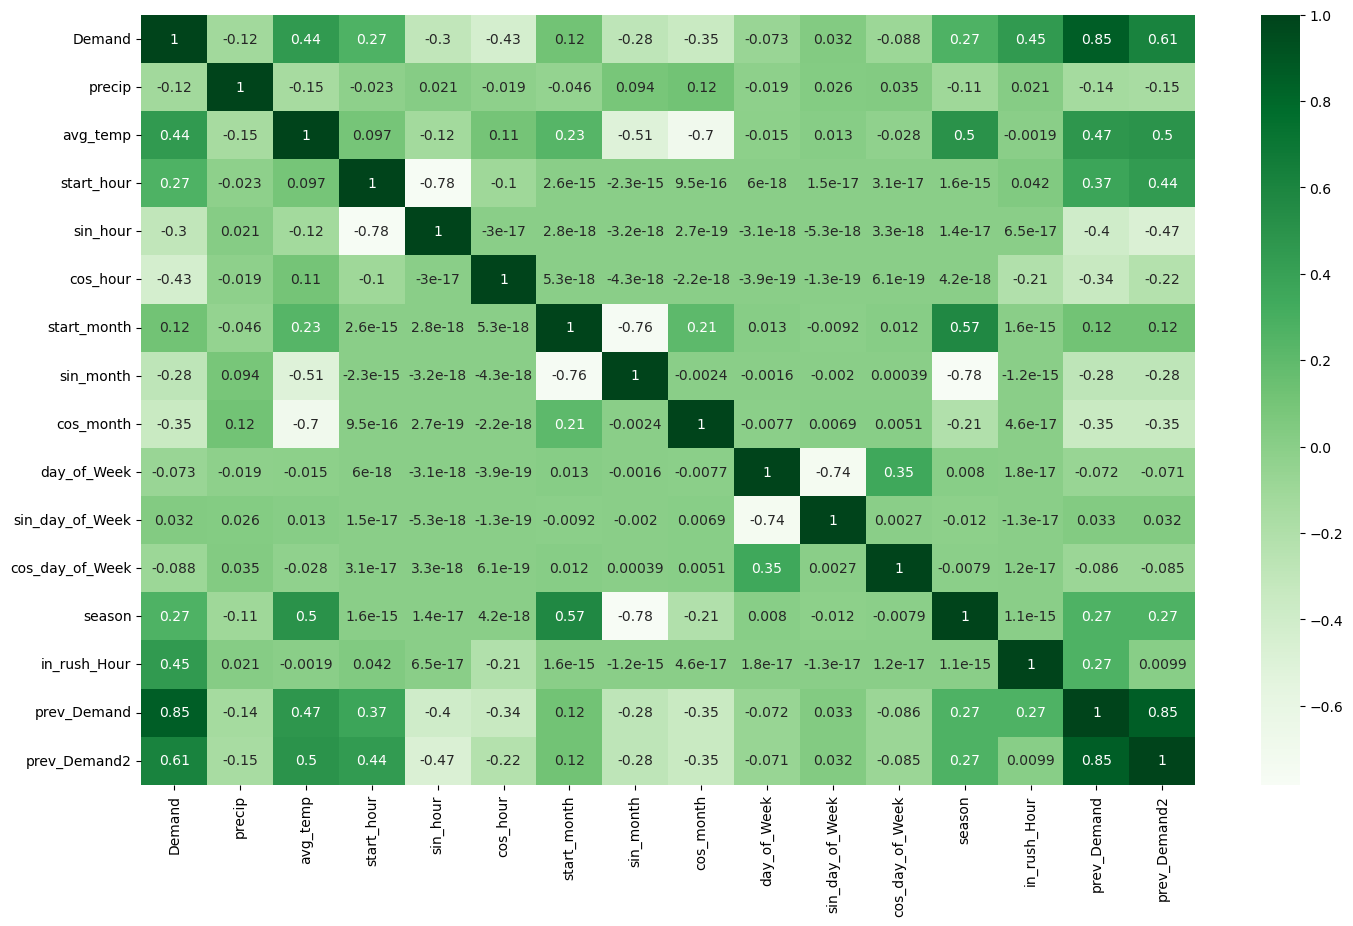

In [54]:
#visualize correlation between features

plt.figure(figsize=(17,10))
sns.heatmap(df_load_weather.corr(), cmap = 'Greens', annot = True)
plt.show()

In [55]:
# Since prev_Demand and prev_Demand2 seem to be highly correlated, we will drop prev_Demand2 as a feature
# Doing this, protects our model from considering unnecessary/redundant features and prevent the performance
# from being harmed

df_load_weather.drop('prev_Demand2', axis = 1, inplace = True)
df_load_weather.head(1)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand
0,2018-01-01,7,0.0,-13.9,0,0.0,1.0,1,0.5,0.866025,1,0.781831,0.62349,1,0,NaN


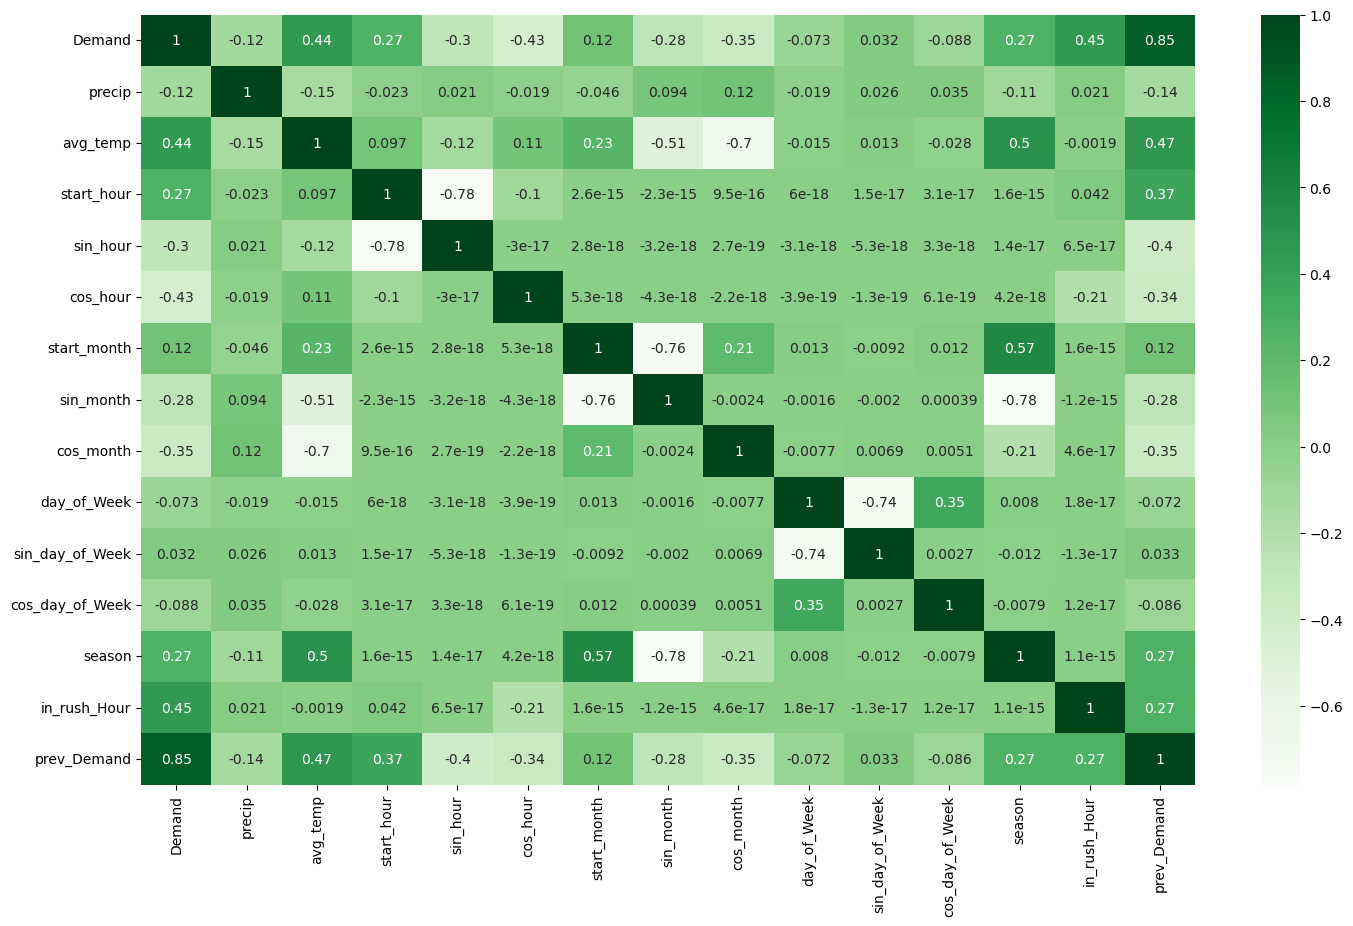

In [56]:
# Show new correlation matrix
plt.figure(figsize=(17,10))
sns.heatmap(df_load_weather.corr(), cmap = 'Greens', annot = True)
plt.show()

In [380]:
# the correlation matrix paints the same picture, as our feature selecting lasso regression earlier

In [384]:
# Regression
# We already have quite the clear picture on how important our features are, based on our Lasso Regression earlier
#test